# PRACTICA 1 - APRENENTATGE COMPUTACIONAL
Integrants: Álvaro Díaz 1639484, Jan Planas 1636492, David Fuentes 1637892

## ANÀLISIS TITANIC


Importació de llibreries útils per la pràctica. Compararem resultats entre tres tipus de classificadors diferents. En aquest cas, són: KNN, Random Forest i SVC.

In [303]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve, roc_auc_score, auc, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, classification_report, average_precision_score

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

## 1. EDA - Exploratory data analysis

En aquest apartat farem un analisis complert de les dades. 

In [200]:
titanic_data = pd.read_csv("train.csv")

titanic_data.info()
print()
print(f"El shape del train-data es {titanic_data.shape}.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

El shape del train-data es (891, 12).


Aquesta serà la nostra primera visualització de les característiques del dataset. Podem distingir diversa informació important com el shape, el nom dels atributs, la cantitat de valors non-null i els tipus d'atributs. 

La mesura dels datasets és la que es mostrà al output. Per altra banda, els atributs es podem distribuir en numèrics i categòrics. Entre els numèrics tenim: Age, SibSp, Parch i Fare. Pels categòrics tenim: Survived, que també la podem classificar com binaria, Pclass, Sex, Ticket, Cabin i Embarked. Cal dir que no pel fet de ser de tipus int64 o float64 significa que siguin numèriques. Depen del contexte podem tenir altre valor.

Respecte el target d'aquest analisis, estarem intentant predir el valor corresponent a la columna Survived de les dades del conjunt de test. Aquest atribut el podem classificar com binari perquè ha de predir Survived = 1 i no-Survived = 0.

La funció info() ja ho mostrava, pero per més claretat, anem a veure si tenim NaNs als nostres datasets.

In [201]:
print(titanic_data.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Podem veure com tenim valors NaN a les columnes de Age, Cabin i a Embarked. Sabent això, més endavant podrem decidir que fer amb aquests valors.

Caldria fer un analisi més visual. Utilitzem la llibreria matplotlib. Voldrem entrendre les distribucions de les variables numèriques i categoriques i comparar-les amb el target per veure correlacions. 

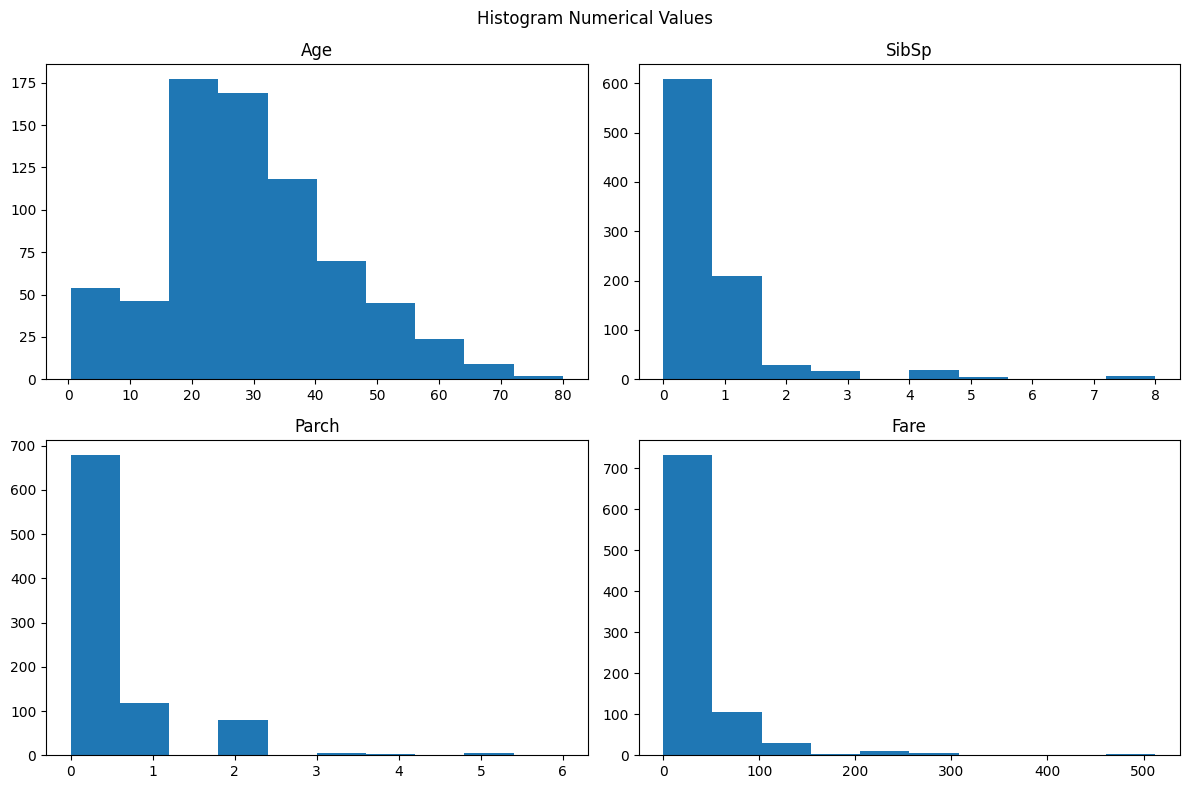

In [202]:
df_num = titanic_data[['Age','SibSp','Parch','Fare']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()
plt.show()

En aquest histogrames de atributs numérics, el que més destaca principalment es la distribució del Fare totalment desproporcionada, encara que també ho estan SibSp i Parch. En el cas de Age, esta bastant bé distribuit. Caldria balancejar las dades per tal de que a l'hora de fer el model doni resultats inesperats per un Overfitting al tenir més dades d'una classe o un conjunt de classes que d'altra, per exemple al cas de Fare.

Abans de realitzar el model, caldria normalitzar les dades i escalarles seguidament.

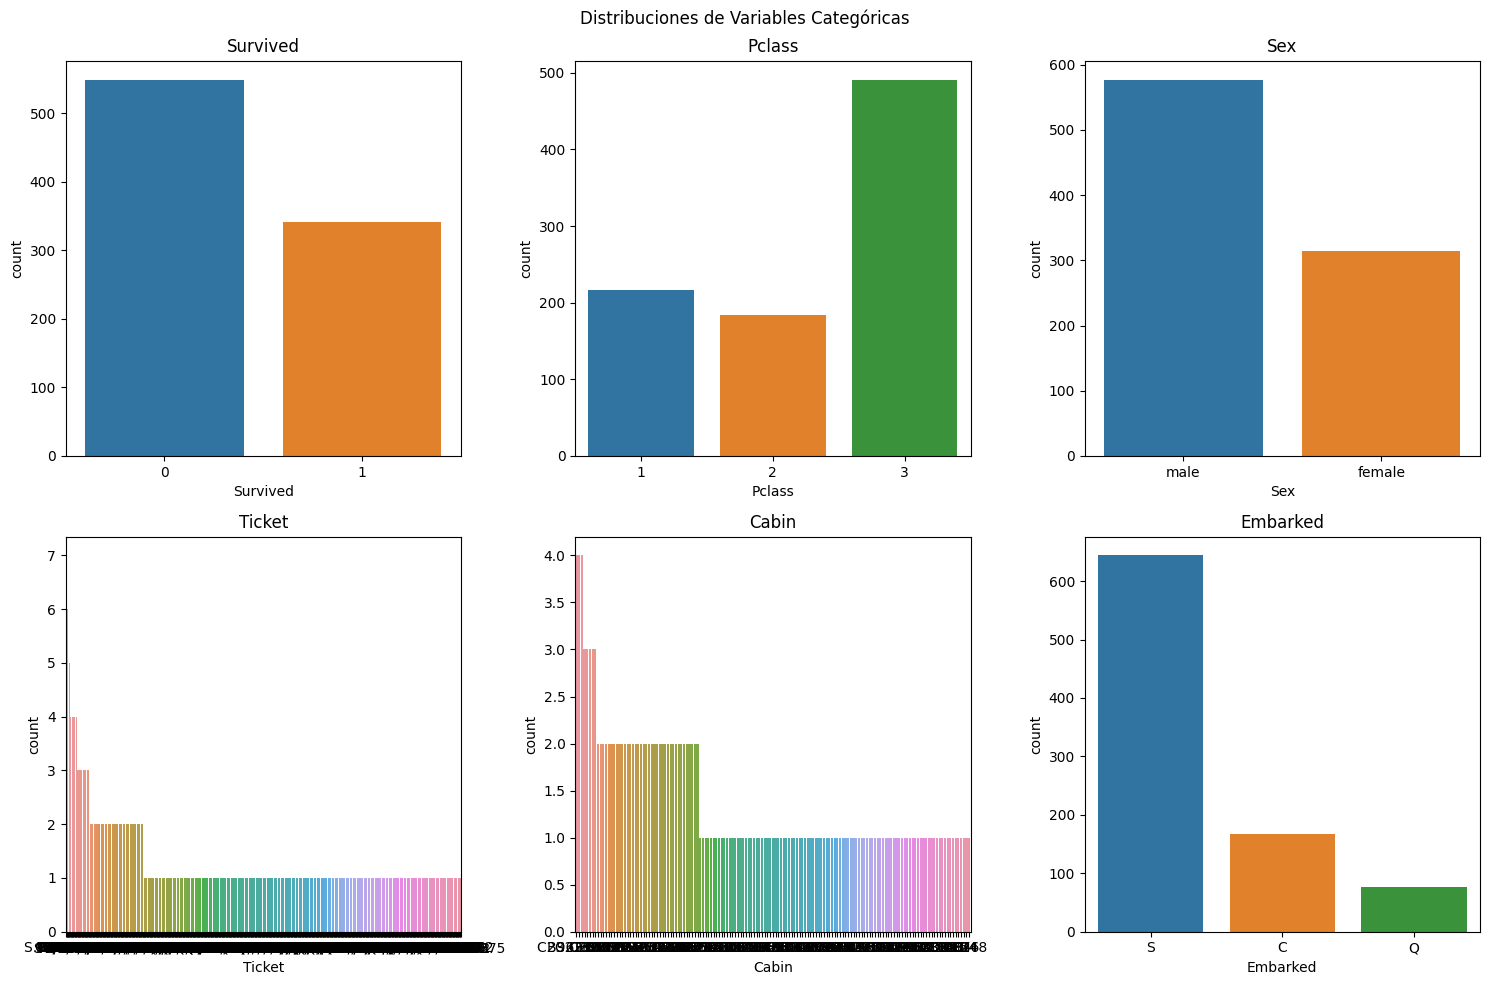

In [203]:
df_cat = titanic_data[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribuciones de Variables Categóricas')

for i, ax in enumerate(axes.ravel()):
    if i < df_cat.shape[1]:
        column_name = df_cat.columns[i]
        sns.barplot(x=df_cat[column_name].value_counts().index, y=df_cat[column_name].value_counts(), ax=ax)
        ax.set_title(column_name)

plt.tight_layout()
plt.show()

Aquesta seria la distribució de cada atribut categòric, inclús el target, on podem veure que a Ticket i Cabin tenen molts valors diferents pel que no ens serveix com per analitzar les correlacions amb survived. Name directament al tenir tot valors únics, no el podem analitzar com aquest altres. En cas de la resta, la distribució mostra una classe predominant sempre.

Pel cas de les correlacions, mirarem primer las variables númeriques.

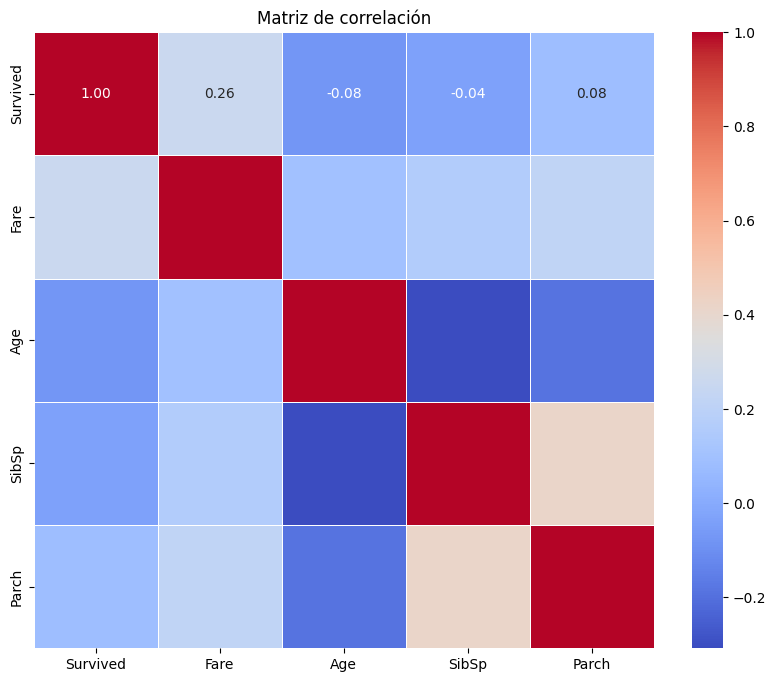

In [204]:
correlation_matrix = titanic_data[['Survived', 'Fare', 'Age', 'SibSp', 'Parch']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de correlación')
plt.show()

L'única fila que ens interessa veure es la primera on tenim les correlacions de les variables númeriques respecte la variable survived. Podem veure una correl·lació important entre SibSp i Parch, o per exemple entre Age i SibSp encara que és negativa. 

Respecte Survived, la correl·lació més gran que trobem, es amb la característica Fare. Això pot significar que Fare, com té una possible relació amb la Pclass, si pagaves més signfica classe més alta i, per tant, més probabilitats de sobreviure. En canvi, a preus més baixos, una classe més baixa i, per tant, més probabilitats de morir.

Pel cas de les variables categoriques, en comptes de mirar-ho a partir de una matriu, utilitzarem les pivot tables per trobar relacions. Només farem un print d'aquelles que no tenen multiples classes com ho són Ticket, Cabin o Name, on pràcticament trobem valors únics.

In [205]:
pd.pivot_table(titanic_data, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [206]:
pd.pivot_table(titanic_data, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count')

Sex,female,male
Survived,,
0,81,468
1,233,109


In [207]:
pd.pivot_table(titanic_data, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


Aquestes serien les distribucions dels atributs respecte el target Survived. Veiem una correlació important de Sex amb Survived que mostra que la majoria de 0s corresponen amb homes i la majoria d'1s amb dones. A la resta també es poden observar correlacions com que si ets de classe 3 tens més probabilitats de morir, el que ens confirma la hipotesis anterior sobre la correl·lació entre Fare i Survived. A Embarked, encara que la majoria de morts es troba a S, esta proporcionat amb la resta de classes, per tant, podem veure que la seva correlació es bastant poca. 

## 2. Preprocessing

En aquest apartat procedirem a realitzar una preparació de les dades pel model.

Començarem amb l'eliminació de NaNs. Com ja vam veure abans, al dataset tenim NaNs a uns quants atributs. Podem decidir que fem amb ells tenint en compte la seva importancia respecte la predicció de Survived.

### NaNs Treatment
#### Cabin

Ara volem veure la relació que té la cabina que tens assignada respecte la teva classe com a passatger (Pclass). Hem fet una cerca a internet i hem vist que la lletra de la cabina era per identificar la planta a on et trobaves i las primeres lletres eran las que es trobaven més a dalt, tenint en compte que la A es la coberta.

In [208]:
titanic_data['cabin_letter'] = titanic_data.Cabin.apply(lambda x: str(x)[0])
pd.pivot_table(titanic_data,index='Pclass',columns='cabin_letter', values = 'Name', aggfunc='count')

cabin_letter,A,B,C,D,E,F,G,T,n
Pclass,,,,,,,,,
1,15.0,47.0,59.0,29.0,25.0,NaN,NaN,1.0,40.0
2,NaN,NaN,NaN,4.0,4.0,8.0,NaN,NaN,168.0
3,NaN,NaN,NaN,NaN,3.0,5.0,4.0,NaN,479.0


Mirant aquesta correlació ens adonem que tenim un únic valor que té assignat la T. La resta dels valors amb aquesta classe són NaNs, per tant, hem decidit obviar-ho i eliminar aquesta única fila. A més que cercant a internet no hem trobat cap cabina que contigui la lletra T, així que suposem que és un error.

La següent funció, emplena els NaNs que trobem a la categoria Cabina (on hi més percentatge de NaNs). No hem considerat la seva eliminació perquè ho considerem un element clau per a la predicció final. Tenim en consideració que quan més alta es la classe, més a dalt et trobaves.

In [209]:
import random
def agregar_probabilidades_planta(dataframe):
    def asignar_planta(row):
        if row['cabin_letter'] != 'n':
            return ord(str(row['cabin_letter'])) - 64
        pclass = row['Pclass']
        if pclass == 1:
            return random.choices([1, 2, 3, 4, 5], weights=[0.05, 0.3, 0.4, 0.15, 0.1])[0]
        elif pclass == 2:
            return random.choices([3, 4, 5, 6], weights=[0.2, 0.3, 0.3, 0.2])[0]
        elif pclass == 3:
            return random.choices([5, 6, 7], weights=[0.2, 0.4, 0.4])[0]

    dataframe['Floor'] = dataframe.apply(asignar_planta, axis=1)
    
    return dataframe

titanic_data['cabin_letter'] = titanic_data.Cabin.apply(lambda x: str(x)[0])

titanic_data = agregar_probabilidades_planta(titanic_data)
titanic_data = titanic_data[titanic_data['Floor'] != 20]

print(titanic_data.isna().sum())
pd.pivot_table(titanic_data, index = 'Pclass', columns = 'Floor', values = 'Ticket' ,aggfunc ='count')

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
cabin_letter      0
Floor             0
dtype: int64


Floor,1,2,3,4,5,6,7
Pclass,,,,,,,
1,17.0,59.0,73.0,37.0,29.0,NaN,NaN
2,NaN,NaN,35.0,53.0,52.0,44.0,NaN
3,NaN,NaN,NaN,NaN,94.0,175.0,222.0


El resultat ens mostra com ja omplert les dades, on la suma total ens donarà la quantitat exacta de files que tenim menys una. Per millor comprensió hem canviat las lletres per números i ho hem assignat al atribut Floor. Cabin ja no ens servirà i per tant, ho podrem eliminar.

Com a petita justificació de l'eliminació del Cabin després d'aquest fill podem dir que d'aquesta columna només ens interesava la lletra. El valor numèric no donava res d'informació pel que hem cercat a la web. No tenia relació directa amb la classe o posició dins del titanic, per tant, ja no farem servir més aquesta columna. 

In [210]:
titanic_data = titanic_data.drop(['Cabin', 'cabin_letter'], axis = 1)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 890 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  890 non-null    int64  
 1   Survived     890 non-null    int64  
 2   Pclass       890 non-null    int64  
 3   Name         890 non-null    object 
 4   Sex          890 non-null    object 
 5   Age          713 non-null    float64
 6   SibSp        890 non-null    int64  
 7   Parch        890 non-null    int64  
 8   Ticket       890 non-null    object 
 9   Fare         890 non-null    float64
 10  Embarked     888 non-null    object 
 11  Floor        890 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 90.4+ KB


#### Embarked

La següent columna amb NaNs que tractarem és Embarked on trobem únicament dos a tot el dataset. 

In [211]:
pd.pivot_table(titanic_data,index='Embarked',columns='Pclass', values = 'Ticket', aggfunc='count') 

Pclass,1,2,3
Embarked,,,
C,85,17,66
Q,2,3,72
S,126,164,353


In [212]:
titanic_data[titanic_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Floor
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,2
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,2


Al ser els dos nans de la Pclass 1 hem decidit omplir-los amb el valor Embarked C ja que és on per proporció es hi ha més gent de la Pclass 1.

In [213]:
titanic_data.loc[titanic_data['Embarked'].isna(), 'Embarked'] = 'S'
print(titanic_data.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Floor            0
dtype: int64


#### Age
Per últim, farem el fill dels Age. La idea principal d'aquest tractament de NaNs es fer un fill segons una aproximació de edats a partir dels titols dels noms que té cadascú.

In [214]:
titanic_data['name_title'] = titanic_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
nan_counts_by_title = titanic_data.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title

name_title
Capt              0
Col               0
Don               0
Dr                1
Jonkheer          0
Lady              0
Major             0
Master            4
Miss             36
Mlle              0
Mme               0
Mr              119
Mrs              17
Ms                0
Rev               0
Sir               0
the Countess      0
Name: Age, dtype: int64

El que hem fet primer és crear un nou atribut que té com a classes els títols dels nombres que ens servirà per classificar les edats de cadascuna de les persones. Com veiem, tenim un baix percentatge de NaNs a Dr, Master, Miss, Mrs i Ms. Mr té quasi quatre vegades més NaNs que Miss per tant, aplicarem una tècnica de fill diferent.

Pel baix percentatge, l'únic que farem serà omplir amb la mitjà d'edat de les persones que tenen el mateix name_title.

In [215]:
media_por_name_title = titanic_data.groupby('name_title')['Age'].agg(['mean', 'std','count'])
media_por_name_title

,mean,std,count
name_title,,,
Capt,70.000000,NaN,1
Col,58.000000,2.828427,2
Don,40.000000,NaN,1
Dr,42.000000,12.016655,6
Jonkheer,38.000000,NaN,1
Lady,48.000000,NaN,1
Major,48.500000,4.949747,2
Master,4.574167,3.619872,36
Miss,21.773973,12.990292,146


In [216]:
def agregar_probabilidades_edad(dataframe, media_por_name_title):
    def asignar_edad(row):
        if pd.isna(row['Age']) == True and row['name_title'] != 'Mr':
            return round(media_por_name_title['mean'][row['name_title']])
        return row['Age']

    dataframe['Age'] = dataframe.apply(asignar_edad, axis=1)

    return dataframe

titanic_data = agregar_probabilidades_edad(titanic_data, media_por_name_title)

nan_counts_by_title = titanic_data.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title


name_title
Capt              0
Col               0
Don               0
Dr                0
Jonkheer          0
Lady              0
Major             0
Master            0
Miss              0
Mlle              0
Mme               0
Mr              119
Mrs               0
Ms                0
Rev               0
Sir               0
the Countess      0
Name: Age, dtype: int64

Com veiem, hem omplert tots els NaNs que no són de Mr. 

Després, farem una clusterització. Agafarem totes les persones amb name_title = Mr i farem un KNNImputer peromplir els NaNs que ens falten en funció del cluster on es classifica. Aquesta clusterització la farem després de de la normalització i de l'encoding ja que ens servirà per classificar millor els nans de Mr.

Mentrestant, com a resultat, tenim totes les categories omplenades (menys els ages de Mr) segons les relacions que tenen amb la resta de dades i en un contexte correcte amb diferents mètodes que permeten aproximar-nos encara més a un valor que sigui el més realista possible.

El principal motiu de no eliminar cap columna del nostre dataset per molts NaNs que tingui es per no perdre posibles relacions entre categories que porten a un millor rendiment del nostre model. Encara que la quantiat de NaNs sigui molt petita, per entrenar millor el model, ens convé no el·liminar les files ni les columnes amb un gran percentatge de missing values ja que perdem dades importants. 

### Feature Selection

Abans de fer res, hem de tenir en compte que hem d'eliminar columnes que no ens interessen ni per normalitar ni com per fer enconding. Aquest procés és la selecció de característiques.

Dins del nostre dataset n'hi han columnes de dades que són totalment irrellevants per l'aprenentatge del classificador. Una d'aquestes és la de PassengerId on únicament s'ens informa del index de la mostra sense cap correlació amb qualsevol altra dada del dataset. No obstant, altres característiques caldria especificar en detall perquè són el·liminades.

Anem a veure la posible correlació entre l'atribut Ticket i Survived. Al ser una variable categòrica ens fixarem en si que tiquet està format per números només o per números i lletres i veurem els resultats. En cas de que no ens aporti informació nova, eliminarem la columna Ticket ja que no ens servirà per al nostre model.

In [217]:
titanic_data['Numerical_ticket'] = titanic_data.Ticket.apply(lambda x: 1 if x.isdigit() else 0)
pd.pivot_table(titanic_data,index='Numerical_ticket',columns='Survived', values = 'Ticket', aggfunc='count')

Survived,0,1
Numerical_ticket,,
0,142,88
1,406,254


Com podiem intuir, la relació entre Numerical_ticket i Survived no ens aporta molta informació ja que als dos possibles casos, els resultats són proporcionals. Això vol dir que per al nostre model la variable Ticket no ens ajudarà a predir millor i la eliminarem per així aconseguir reduir la dimensionalitat del dataset i que sigui menys complexe.

Finalment també hem decidit eliminar la variable Name, ja que, els noms complets no són gens rellevants però el que si que ens quedarem serà amb el Name_title que ens aporta més informació que l'altre característica.

In [218]:
titanic_data = titanic_data.drop(['Ticket', 'Name', 'PassengerId', 'Numerical_ticket'], axis=1)

In [219]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 890 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    890 non-null    int64  
 1   Pclass      890 non-null    int64  
 2   Sex         890 non-null    object 
 3   Age         771 non-null    float64
 4   SibSp       890 non-null    int64  
 5   Parch       890 non-null    int64  
 6   Fare        890 non-null    float64
 7   Embarked    890 non-null    object 
 8   Floor       890 non-null    int64  
 9   name_title  890 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 76.5+ KB


### Normalitzacion

Com hem dit, proseguirem amb la normalització abans de fer el fill de NaNs d'Age.

El primer que farem serà normalitzar logaritmicament les dades per a que tingui una distribució normal el més semblant possible. Seguidament, escalarem les dades per a que vagin de 0 a 1 com a minim i màxim, amb el Min-Max Scaling.

La normalització logarítmica s'utilitza per transformar dades amb distribucions sesgades o una ampla variabilitat, reduint el sesgament i l'amplitud dels valors. Ajudar a igualar la distribució, estabilitzar la variància, facilitar la interpretació i preparar les dades per a certs models, però la seva aplicabilitat depèn de la naturalesa de les dades i del context del problema.

In [220]:
titanic_data['Fare_norm'] = np.log1p(titanic_data.Fare)
titanic_data['Parch_norm'] = np.log1p(titanic_data.Parch)
titanic_data['Sibsp_norm'] = np.log1p(titanic_data.SibSp)
titanic_data['Age_norm'] = titanic_data.Age

La funció principal del MinMaxScale és escalar les dades entre un rang específic, en aquest cas entre 0 i 1.  
El MinMaxScaler es una técnica de escalado que transforma los datos de tal manera que quedan en un rango específico, generalmente entre 0 y 1. Ens facilita la seva comparació ja que tots les variables categoriques tenen el mateix rang de dades.

In [221]:
scaler = MinMaxScaler()
titanic_data[['Age_norm', 'Sibsp_norm', 'Fare_norm', 'Parch_norm']] = scaler.fit_transform(titanic_data[['Age_norm', 'Sibsp_norm', 'Fare_norm', 'Parch_norm']])
titanic_data.isna().sum()

Survived        0
Pclass          0
Sex             0
Age           119
SibSp           0
Parch           0
Fare            0
Embarked        0
Floor           0
name_title      0
Fare_norm       0
Parch_norm      0
Sibsp_norm      0
Age_norm      119
dtype: int64

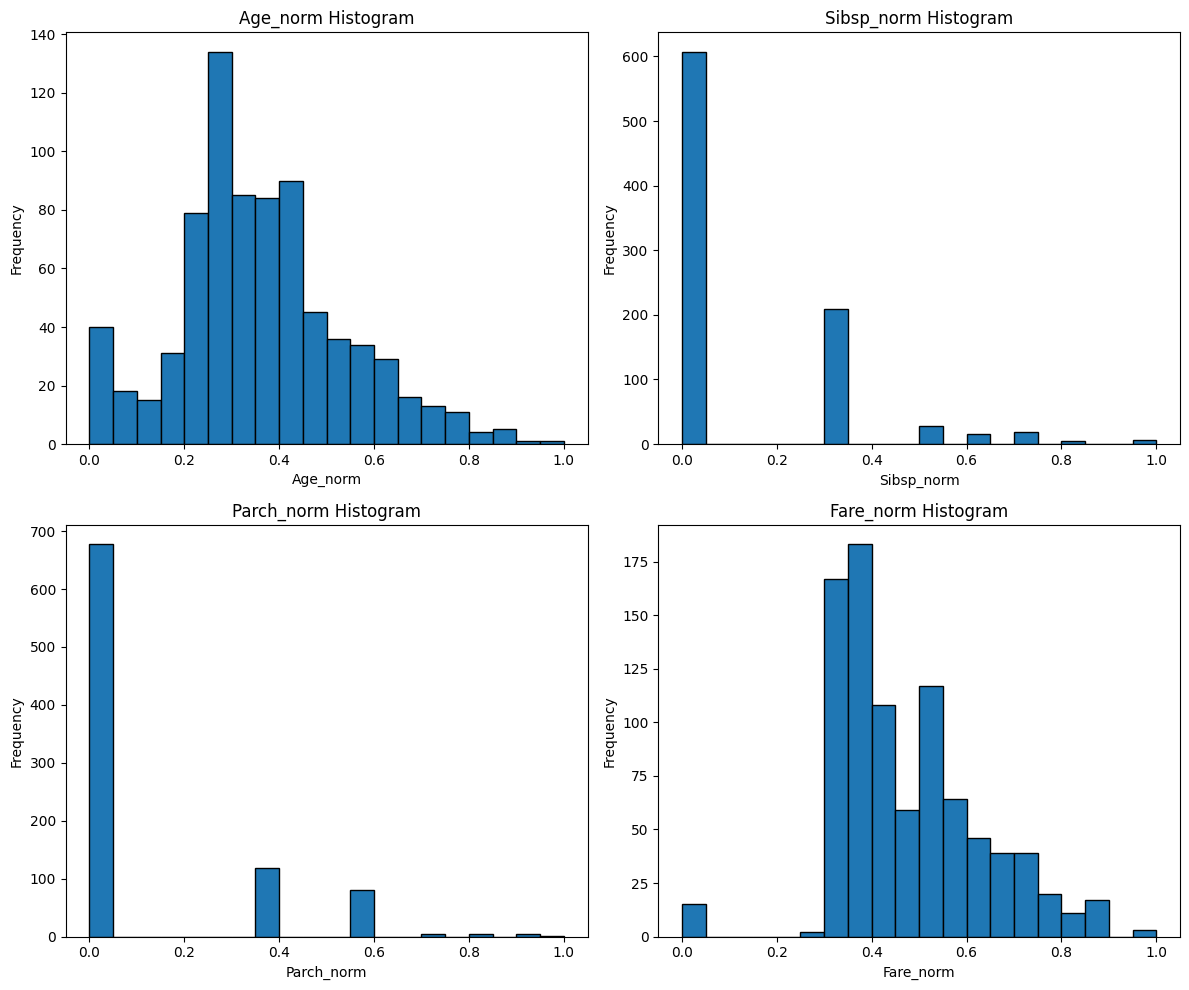

In [222]:
columns = ['Age_norm', 'Sibsp_norm', 'Parch_norm', 'Fare_norm']
titles = ['Age_norm Histogram', 'Sibsp_norm Histogram', 'Parch_norm Histogram', 'Fare_norm Histogram']
xlabels = ['Age_norm', 'Sibsp_norm', 'Parch_norm', 'Fare_norm']

plt.figure(figsize=(12, 10))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(titanic_data[column], bins=20, edgecolor='k')
    plt.title(titles[i - 1])
    plt.xlabel(xlabels[i - 1])
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

titanic_data = titanic_data.drop(['Age','SibSp', 'Parch', 'Fare'], axis=1)

In [223]:
titanic_data

,Survived,Pclass,Sex,Embarked,Floor,name_title,Fare_norm,Parch_norm,Sibsp_norm,Age_norm
0,0,3,male,S,7,Mr,0.338125,0.000000,0.315465,0.271174
1,1,1,female,C,3,Mrs,0.685892,0.000000,0.315465,0.472229
2,1,3,female,S,7,Miss,0.350727,0.000000,0.000000,0.321438
3,1,1,female,S,3,Mrs,0.639463,0.000000,0.315465,0.434531
4,0,3,male,S,7,Mr,0.352955,0.000000,0.000000,0.434531
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,S,3,Rev,0.422864,0.000000,0.000000,0.334004
887,1,1,female,S,2,Miss,0.550238,0.000000,0.000000,0.233476
888,0,3,female,S,7,Miss,0.512205,0.564575,0.315465,0.271174
889,1,1,male,C,3,Mr,0.550238,0.000000,0.000000,0.321438


### Encoding

Per poder entrenar sense problemes el model haurem de fer encoding a les variables categòriques. Les que tenim són: Embarked, Name_title, PClass, Floor i Sex. Hem de buscar una bona forma de fer encoding per obtenir un bon rendiment al model.

Per realitzar aquesta tasca hem de pensar quin encoder utilitzar. Al observar les dades ens en adonem que no segueixen cap ordre intrinsic, aleshores hem d'utilitzar la codificació One Hot Encoder, sinó el model interpretaria malament les dades i obtindriem un mal rendiment. One Hot Encoder ens afegeix una columna nova per cadascuna de les classes de la columna codificada i posa un 1 a la fila que correspon amb la categoria. Encara que augmenta la dimensionalitat de les dades, creime que es la millor opció.

In [224]:
titanic_data_RF = titanic_data.copy()

categorical_attributes = ['name_title', 'Embarked', 'Sex', 'Floor', 'Pclass']

for attribute in categorical_attributes:
    encoder = OneHotEncoder(sparse=False)
    attribute_encoded = encoder.fit_transform(titanic_data[[attribute]])

    new_column_names = encoder.get_feature_names_out(input_features=[attribute])
    encoded_df = pd.DataFrame(attribute_encoded, columns=new_column_names, index=titanic_data.index)

    titanic_data = titanic_data.drop([attribute], axis=1)
    titanic_data = pd.concat([titanic_data, encoded_df], axis=1)

titanic_data

,Survived,Fare_norm,Parch_norm,Sibsp_norm,Age_norm,name_title_Capt,name_title_Col,name_title_Don,name_title_Dr,name_title_Jonkheer,...,Floor_1,Floor_2,Floor_3,Floor_4,Floor_5,Floor_6,Floor_7,Pclass_1,Pclass_2,Pclass_3
0,0,0.338125,0.000000,0.315465,0.271174,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0.685892,0.000000,0.315465,0.472229,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,0.350727,0.000000,0.000000,0.321438,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0.639463,0.000000,0.315465,0.434531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0.352955,0.000000,0.000000,0.434531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.422864,0.000000,0.000000,0.334004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
887,1,0.550238,0.000000,0.000000,0.233476,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
888,0,0.512205,0.564575,0.315465,0.271174,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,0.550238,0.000000,0.000000,0.321438,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Podem veure que ha afegit 27 columnes noves que corresponen amb cadascuna de les classes de la categoria name_title, PClass, Sex, Floor i Embarked. Per tant, com ja hem encoding a les variables categoriques, ja no hi haurà problemes alhora de entrenar el model, encara que classificadors com Random Forest admeten variables categoriques.

Finalment ara farem el KNNImputer, amb n_neighbors=5, per acabar d'omplir els nans de els ages de Mr.

In [225]:
imputer = KNNImputer(n_neighbors=5)

X_imputed = imputer.fit_transform(titanic_data)

titanic_data = pd.DataFrame(X_imputed, columns=titanic_data.columns)

In [226]:
print("Nombre de NaNs total al dataset: " ,titanic_data.isna().sum().sum())

Nombre de NaNs total al dataset:  0


## 3. Metric selection 

Per a mesurar la qualitat d'un model tenim diferents mètriques. 
- **Accuracy**: Mesura la proporció de prediccions correctes en comparació amb el total de prediccions. És una mètrica adequada quan les classes estan balancejades i totes les classes són igualment importants. No obstant això, en casos de classes desbalancejades, la precisió pot ser enganyosa, ja que un model que prediu sempre la classe majoritària podria tenir una alta precisió però no ser útil en la pràctica.

- **F1-SCORE**: És una mètrica que combina la precisió i el recall. L'F1-score és útil quan tens un desequilibri en les classes o quan estàs més interessat en l'equilibri entre les prediccions correctes de totes dues classes (veritables positius) i en minimitzar tant els falsos positius com els falsos negatius. És especialment útil en problemes de detecció d'anomalies o en aquells en què una classe és més important que l'altre.

- **Average_presicion_score**: Mesura la precisió mitjana d'un model en la recuperació de totes les classes. És especialment útil quan et preocupen les taxes de falsos positius i veritables positius en problemes de recuperació d'informació o classificació de documents, on cal donar prioritat a la recuperació d'elements rellevants.

Dit això per a l'avaluació del nostre model ens quedarem amb la F1-score ja que és útil quan tractem dades desbalancejades. La metrica Accuracy no ens interessa tant per aquest mateix factor, ja que un conjunt desbalancejat l'únic que portaria serien confusions. F1-score considera falsos positius com falsos negatius por tant una mesura més equilibrada. 

També cerquem un equilibri entre les prediccions correctes de totes dues classes, ja que al estar predint si es sobreviurà o no, volem minimitzar els falsos positius i negatius, cosa que no es valora en el average_presicion_score, tot i que també és bo tractant desequilibir entre classes. 

Average_precision_score:  0.6882235510613368 

F1-score macro:  0.8150397288077039 

Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       548
         1.0       0.79      0.75      0.77       342

    accuracy                           0.83       890
   macro avg       0.82      0.81      0.82       890
weighted avg       0.83      0.83      0.83       890



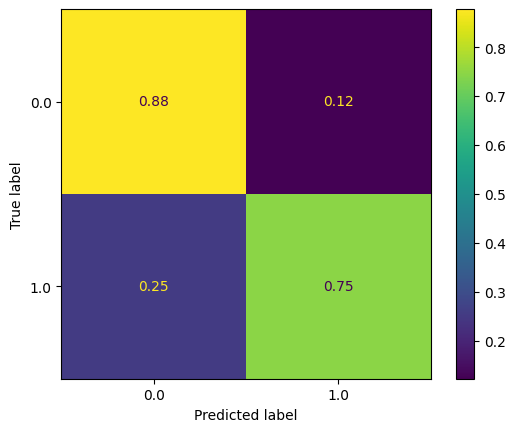

In [227]:
X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived']

model = LogisticRegression()

model.fit(X, y)
y_pred = model.predict(X)

f1 = f1_score(y, y_pred, average='macro')
accuracy = accuracy_score(y, y_pred)
confusion = ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true')
report = classification_report(y, y_pred)
average_precision = average_precision_score(y, y_pred)
print("Average_precision_score: ", average_precision, '\n')
print("F1-score macro: ", f1, '\n')
print("Informe de Clasificación:")
print(report)

Podem observar com la funció classification_report ens mostra les mètriques principals de classificació: accuracy, presicion, recall i f1-score, útils en l'avaluació del model. Com hem dit abans, ens centrarem sobretot en la f1-score per tal d'optimitzar el nostre classificador, pero això no treu que ens interessi veure també les mètriques accuracy i precision.

En general, els resultats del report mostren un bon rendiment. No obstant, com aquest model només ens serveix per saber quina mètrica de avaluació escollim, no podem treure cap conclusió fins que no fem el Model Selection on a més escollirem els paràmetres mes adients per l'entrenament i el model idoni.

Altres maneres d'avaluar un model és fent servir les corves ROC i PR.
- **ROC-AUC**: en poques paraules és l'àrea sota la corba on l'eix X és la taxa de fals positius (FPR - Positives / All Negatives) i l'eix Y és la taxa de vertaders positius (TPR - True Positives / All Positives). Especialment útil per mesurar la capacitat d'un model de distingir entre les classes en funció de TPR I FPR.
- **PR-AUC**: aquesta és l'àrea sota la corba on l'eix X és la mètrica Recall (el mateix que TPR) i l'eix Y és Precision (True Positives / True + False Positives). Especialment útil en situacions de desbalanceig de classes.

Podem veure que hi ha un mateix eix pels dos, que es el True Positives Rate (TPR). No obstant, les diferències entre totes dues són significatives. La corba ROC ens mesura la capacitat que té el model per distingir classes a l'espai, mentre que la corba PR es fixa bàsicament en veure com de bé estan fetes les prediccions de la classe positiva. També podem distingir el seu funcionament respecte el tipus de conjunt de dades. Si tractem dades desbalancejades, la corva PR es idonia ja que destaca en predir correctament la classe minoritaria. En canvi, la corva ROC és més util quan les dades estan balancejades.

Per aquest últim motiu, associant-lo al nostre cas, donat que l'equilibri de les classes és un factor important ja que tenim més dades associades a la classe negativa que a la positiva, creiem que ens serà més útil utilitzar la corva PR per l'anàlisi final.

Funcions per a mostrar les corbes ROC i PR.

In [286]:
def print_ROC_curve(y ,y_preds, classifier):
    plt.figure(figsize=(12, 6))

    for model_name, y_scores in zip(classifier.keys(), y_preds):
        fpr, tpr, thresholds_roc = roc_curve(y, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC) = {roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    plt.show()

  
def print_PR_curve(y, y_preds, classifiers):
    plt.figure(figsize=(8, 6))

    for model_name, y_scores in zip(classifiers.keys(), y_preds):
        precision, recall, thresholds = precision_recall_curve(y, y_scores)
        auc_score = auc(recall, precision)
        plt.plot(recall, precision, marker='.', label=f'{model_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [1, 0], 'k--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva de Precisión-Recall')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


#### Corba ROC

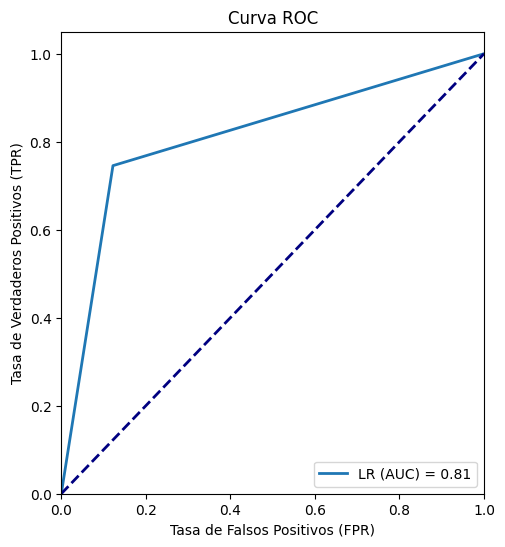

In [287]:
print_ROC_curve(y, [y_pred], {'LR':0})

#### Corba PR

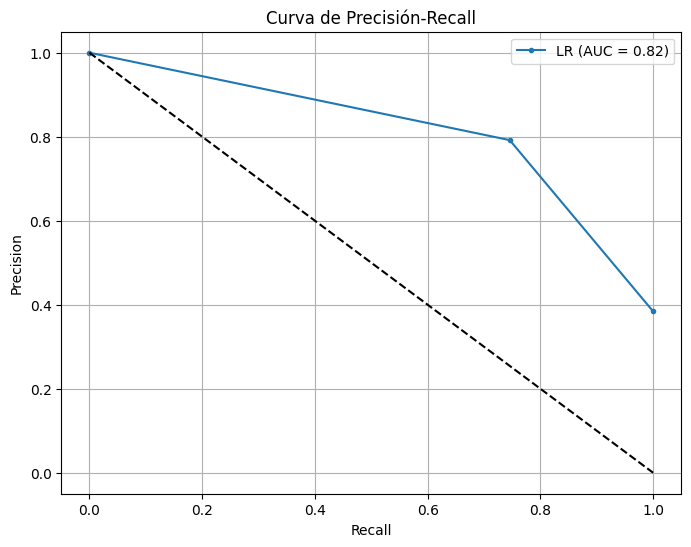

In [276]:
print_PR_curve(y, [y_pred], {'LR':0})

## 4. Model Selection amb validacio creuada

En aquest apartat entrenarem 6 models diferents de classificació. Aquests són: LogisticRegression, SVM, KNN, RandomForest, XGBoost i AdaBoost. La selecció d'aquests classificadors ha estat influenciada pel nostre coneixement actual sobre aquests models. Són models que hem estudiat i coneixem superficialment el seu funcionament. Els avaluarem segons la mètrica de f1-score per decidir quin és el millor.

Per entrenar-los farem servir el cross validation i, posteriorment, farem una cerca d'hiperparàmetres per a que els models puguin ser el mes precisos posible.

És important fer servir la validació creuada a l'entrenament dels models per evitar possibles Overfittings o Underfittings. Sobretot per que tractem amb un dataset desbalancejat, al qual una partició errònia al fer el entrenament ens portaria a resultats no desitjats. 

Una decisió important a la validació és la selecció d'un bon hyperparametre n_splits que és equivalent a la k. Un valor petit com 3 o 5 pot tenir un cost computacional bastant baix, però a la vegada pot provocar major variança i bias. En canvi, un valor alt com 10, encara que té més cost computacional, a canvi tindrà menys variança i bias, aixó doncs obtenim mesures més estables i representatives. 

Resumidament, aquest procediment ens proporciona una mesura del rendiment més que fiable de cada model ja que avalua el comportament del model amb diferents particions.  

Concretament farem servir el StratifiedK-Fold CV el qual divideix el dataset en k particions, assegurant-se que en cada partició es guardi la proporció d'exemples de cada clase del dataset original, entrenant el model amb les k particions i fent la mitja per a quedar-se amb el resultat final. El StratifiedK-Fold CV és més útil que el K-Fold CV quan les dades estan desbalancejades, que és el nostre cas, ja que assegura equitat a la distribució de les classes als subconjunts de dades.

### Entrenament Models amb Hyperparametres per Defecte

In [249]:
f1_scores = {'Sense hyperparametres': {'SVM': 0, 'LR': 0, 'RF': 0, 'XGB': 0, 'ADA': 0}, 'Amb hyperparametres': {'KNN': 0, 'SVM': 0, 'LR': 0, 'RF': 0, 'XGB': 0, 'ADA': 0}}

classifiers = {'RF': RandomForestClassifier(), 'XGB': XGBClassifier(), 'KNN': KNeighborsClassifier(), 'SVM': SVC(), 'LR': LogisticRegression(), 'ADA': AdaBoostClassifier()}

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def avaluacio_models_k_fold(model, stratified_kfold, f1_scores, model_name):
    f1_acc = []
    acc_acc = []
    for i, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        accuracy = accuracy_score(y_test, y_pred)
        f1_acc.append(f1)
        acc_acc.append(accuracy)
    scores = {'f1_macro' : np.array(f1_acc).mean(), 'accuracy' : np.array(acc_acc).mean()}
    f1_scores['Sense hyperparametres'][model_name] = scores

for model_name, model in classifiers.items():
    avaluacio_models_k_fold(model, stratified_kfold, f1_scores, model_name)

In [250]:
f1_scores

{'Sense hyperparametres': {'SVM': {'f1_macro': 0.8028025868535471,
   'accuracy': 0.8258426966292136},
  'LR': {'f1_macro': 0.805621864657738, 'accuracy': 0.8179775280898877},
  'RF': {'f1_macro': 0.8117224438111533, 'accuracy': 0.8247191011235955},
  'XGB': {'f1_macro': 0.8122201873550896, 'accuracy': 0.8235955056179776},
  'ADA': {'f1_macro': 0.8069332161739313, 'accuracy': 0.8179775280898877},
  'KNN': {'f1_macro': 0.7854906923792979, 'accuracy': 0.8033707865168539}},
 'Amb hyperparametres': {'KNN': 0,
  'SVM': 0,
  'LR': 0,
  'RF': 0,
  'XGB': 0,
  'ADA': 0}}

### Cerca d'hyperparametres

Escollir els paràmetres idonis per entrenar el model pot ser una tasca tediosa. Existeixen per això tècniques que et troben la millor combinació d'hyperparametres possible. Aquests són alguns com GridSearchCV, RandomizedSearchCV o HalvingRandomSearchCV.

En termes de cost computacional, podem dir que la primera és la més costosa per la seva exhaustivitat al provar cada combinació possible. Les dues altres opcions, molt menys costoses, poden resultar més eficients en segons que aspectes, però hem de tenir en compte que necessitem la millor combinació possible de hyperparametres. Així doncs, escollim la exhaustivitat del GridSearch respecte la eficiència del RandomizedSearch.

Per analisis encara més profunds, podriem parlar de tècniques de cerca encara més eficients. Aquestes les podem extreure de llibrerias com scikit-optimize. Un possible exemple seria l'optimització Bayesiana. Aquesta modela la funció objectiu i fa la cerca en funció del rendiment, sempre tractant de maximitzar-lo. Altre mètode d'optimització és Tunning, on bàsicament es fa una optimització de hyperparametres per afinar encara més el rendiment en un conjunt de dades específic. No confondre amb el fine-tunning, que no ajusta hyperparametres si no un model entrenat previament.

In [251]:
def grid_search(model, param_grid, X, y, cv):
    start_time = time.time()
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring='f1_macro', cv=cv, verbose=True, n_jobs=-1)
    end_time = time.time()
    duration = end_time - start_time
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(best_params, best_score)
    scores = {'f1_macro' : best_score, 'accuracy' : accuracy}
    return scores, best_params, y_pred, duration


param_grids = {
    'RF': {
        'n_estimators': [400,450,500,550],
        'criterion':['gini','entropy'],
        'bootstrap': [True],
        'max_depth': [15, 20, 25],
        'max_features': ['auto','sqrt'],
        'min_samples_leaf': [2,3],
        'min_samples_split': [2,3],
        'random_state': [None, 42]
    },
    'XGB': {
        'n_estimators': [450,500,550],
        'colsample_bytree': [0.75,0.9],
        'max_depth': [None, 5, 15],
        'reg_alpha': [1, 2],
        'reg_lambda': [2, 5],
        'subsample': [0.55, .65],
        'learning_rate':[0.5, 0.1],
        'gamma':[.5,1],
        'min_child_weight':[0.01, 0.1],
        'sampling_method': ['uniform', 'gradient_based']
    },
    'KNN' :
    {'n_neighbors' : [3,5,7,9,12],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree', 'brute'],
              'p' : [1,2,3],
              'leaf_size': [10, 30, 50, 60],
              'metric': ['euclidean', 'manhattan', 'minkowski']},
    'SVM': [
        {'kernel': ['rbf'], 'gamma': [.1,.5,1,2, 5], 'C': [.1, 1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
        {'kernel': ['poly'], 'degree' : [2,3,4], 'C': [.1, 1, 10, 100]}
    ],
    'LR': {
        'max_iter' : [1000, 2000],
        'penalty' : ['l1', 'l2', 'elasticnet'],
        'C' : np.logspace(-4, 4, 20),
        'solver' : ['liblinear',  'saga'],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    'ADA': {
        'n_estimators': [50, 100, 200, 300],  
        'learning_rate': [0.01, 0.1, 1.0, 2.0],  
        'base_estimator': [None], 
        'algorithm': ['SAMME', 'SAMME.R'],
        'random_state': [None, 42, 100],
    }
}

results = []
y_preds = []
for classifier_name, classifier in classifiers.items():
    params = param_grids[classifier_name]
    best_score, best_params, preds, duration = grid_search(classifier, params, X, y, stratified_kfold)
    results.append({
        'Model': classifier_name,
        'Millors Parametres': best_params,
        'Millor Scores': best_score,
        'Time' : duration
    })
    f1_scores['Amb hyperparametres'][classifier_name] = best_score
    y_preds.append(preds)
    print(f1_scores)

Fitting 10 folds for each of 384 candidates, totalling 3840 fits
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': None} 0.824547095002581
{'Sense hyperparametres': {'SVM': {'f1_macro': 0.8028025868535471, 'accuracy': 0.8258426966292136}, 'LR': {'f1_macro': 0.805621864657738, 'accuracy': 0.8179775280898877}, 'RF': {'f1_macro': 0.8117224438111533, 'accuracy': 0.8247191011235955}, 'XGB': {'f1_macro': 0.8122201873550896, 'accuracy': 0.8235955056179776}, 'ADA': {'f1_macro': 0.8069332161739313, 'accuracy': 0.8179775280898877}, 'KNN': {'f1_macro': 0.7854906923792979, 'accuracy': 0.8033707865168539}}, 'Amb hyperparametres': {'KNN': 0, 'SVM': 0, 'LR': 0, 'RF': {'f1_macro': 0.824547095002581, 'accuracy': 0.9157303370786517}, 'XGB': 0, 'ADA': 0}}
Fitting 10 folds for each of 2304 candidates, totalling 23040 fits
{'colsample_bytree': 0.9, 'gamma': 0.5, 'learning_rate': 0.1, 'max_

Després d'obtenir tots els resultats, imprimim una taula per analitzar-lo més fàcilment.

In [267]:
results_2 = []
for result in results:
    results_2.append({
        'Model': result['Model'],
        'Millors Parametres': result['Millors Parametres'],
        'Millor Scores F1': result['Millor Scores']['f1_macro'],
        'Millor Scores Accuracy': result['Millor Scores']['accuracy'],
        'Time': result['Time']
    })

df = pd.DataFrame(results_2)
df

,Model,Millors Parametres,Millor Scores F1,Millor Scores Accuracy,Time
0,RF,"{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': None}",0.824547,0.915730,0.0
1,XGB,"{'colsample_bytree': 0.9, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.01, 'n_estimators': 450, 'reg_alpha': 1, 'reg_lambda': 2, 'sampling_method': 'uniform', 'subsamp...",0.832390,0.921348,0.0
2,KNN,"{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.793687,0.880899,0.0
3,SVM,"{'C': 100, 'kernel': 'linear'}",0.813525,0.832584,0.0
4,LR,"{'C': 0.615848211066026, 'l1_ratio': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.813677,0.830337,0.0
5,ADA,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 200, 'random_state': None}",0.814729,0.837079,0.0


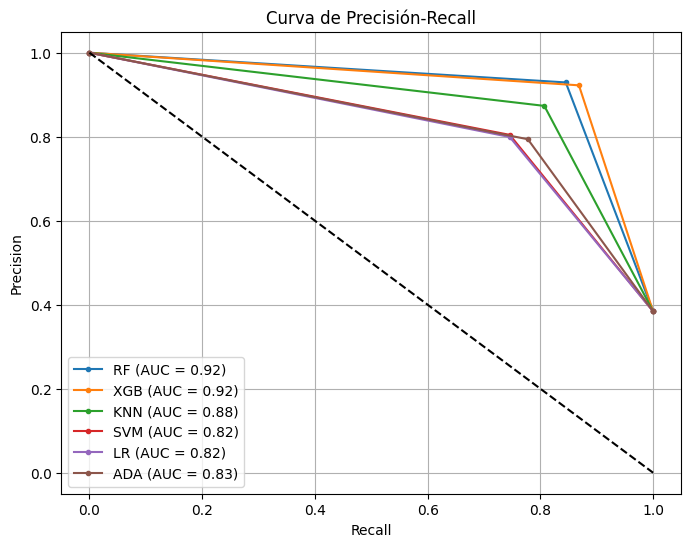

In [288]:
print_PR_curve(y, y_preds, classifiers)

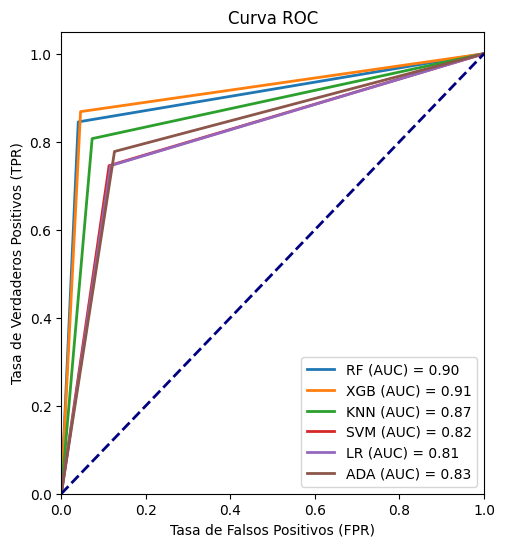

In [289]:
print_ROC_curve(y, y_preds, classifiers)

## 5. Analisi Final

Analitzant els resultats anteriors hem decidit que el millor model per al nostre cas es XGB. Ara entrenarem el model de nou amb els hyperparametres òptims trobats al GridSearchCV.  

Com a diferentes metriques trobem les següents: Accuracy, Precision, Recall, Specificity, F1-Score i les corves PR i ROC. 
Com ja vam comentar abans, les metriques que creiem més adients al nostre problema són les F1-Score i la corva PR. Això és bàsicament per que són més ideals per a conjunts desbalancejtas. Altres mètriques com Accuracy poden generar males representacions dels resultats perquè no tenen en consideració els desbalancejos del dataset.

In [309]:
X_train_list, y_train_list, X_test_list, y_test_list = [], [], [], []

for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_list.extend(X_train)
    y_train_list.extend(y_train)
    X_test_list.extend(X_test)
    y_test_list.extend(y_test)
    
xgb_model = XGBClassifier(**results[1]['Millors Parametres'])

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1-score del modelo: {f1:.2f}')
print(f'Accuracy del modelo: {accuracy:.2f}')

F1-score del modelo: 0.87
Accuracy del modelo: 0.88


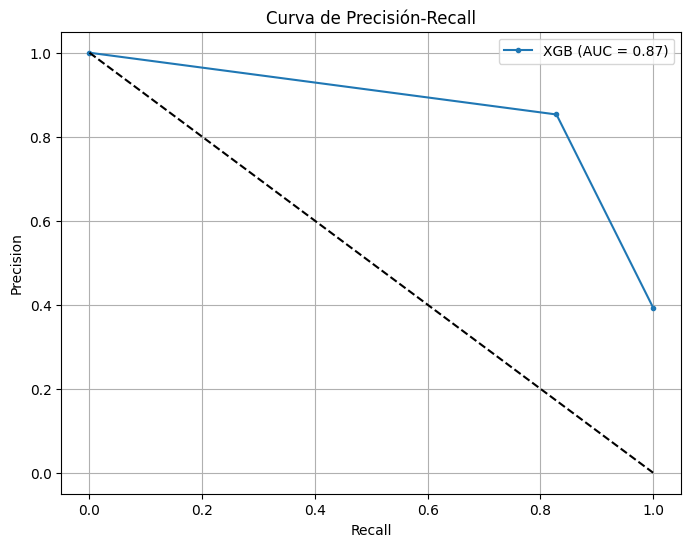

In [307]:
print_PR_curve(y_test,[y_pred], {'XGB' : 0})

Aquest model es podria fer servir per a millorar la seguretat en creuers i embarcacions ja que podria ajudar a planejar estrategies d'evacuació per als diferents perfils de passatgers dels vaixells. També seria útil en un àmbit similar ja que pots fer una segmentació de passatgers en funció del risc i així poder fer una assignació òptima de recursos de seguretat en situacions d'emergència.

Reconeixem que el nostre model no és perfecte i, per tant, existirien àrees que podrien ser millorades potencialment. Una d'aquestes àrees seria el Feature Engineering. Aquest procés implica la creació de noves columnes basades en les columnes originals del conjunt de dades per proporcionar informació addicional. Per exemple, en el cas de la columna Name, inicialment podria semblar que no té rellevància, no obstant això, un anàlisi més detallat revela que inclou títols de cortesia que poden oferir informació rellevant sobre l'edat o la classe social.

Una altra millora podria ser l'òptim ajust dels hiperparàmetres del model. L'ús de tècniques com Tunning o l'optimització Bayesiana podrien proporcionar un rendiment millor dels hiperparàmetres, especialment quan els recursos temporals o computacionals són limitats.

Tot i així, considerem que hem realitzat un bon treball en el model, aplicant processos que inclouen la normalització de classes, la validació creuada, la cerca de hiperparàmetres, entre altres. Tot i que els resultats són coherents, reconeixem que encara hi ha espai per millorar el rendiment del model.

En resum, el nostre model és el resultat d'una sèrie de procediments aplicats, i estem conscients que encara podria ser afinat per aconseguir resultats encara més òptims.